# DNV overrepresentation in network proximity to high confidence genes

- First run network propagation from each high confidence set, on each interactome (use AWS_z_score.py  - we ran it on AWS).  Requires graphs in gpickle format, and high confidence gene sets.

In [1]:
# import matplotlib
# matplotlib.use('TkAgg')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import community

from scipy.stats import mannwhitneyu

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

sns.set_style('white')

import sys

sys.path.append('../../code/')
import load_interactomes


import visJS2jupyter.visJS_module
import visJS2jupyter.visualizations



% matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [3]:
# also import network_utilities, for degree and topology preserving node permutation method
# from https://github.com/emreg00/toolbox
import network_utilities
import gseapy

GenRev not found, steiner wont work


In [4]:
# Some gene symbols in the data were not consistent with networks -- load mapping
map_old_new = pd.read_csv('../../data/ASD_EPI_CHD_HC_and_DNVs_symbol_gene_description.txt',sep='\t')
map_old_new.index=map_old_new['original_symbol']
map_old_new = map_old_new['symbol']
map_old_new.head()

original_symbol
A2M          A2M
A2ML1      A2ML1
AASS        AASS
ABCA1      ABCA1
ABCA13    ABCA13
Name: symbol, dtype: object

# Load ASD, EPI, CHD genesets

ASD HC genes come from table 4 in http://www.cell.com/neuron/fulltext/S0896-6273(15)00773-4 

In [43]:
# ------- ASD HC genes -------

ASD_HC = pd.read_csv('../../data/ASD_HC.txt',names=['HC_genes'])

ASD_HC = ASD_HC['HC_genes'].tolist()
len(ASD_HC)



65

In [6]:
# Load DNVs from Epilepsy paper (http://www.sciencedirect.com/science/article/pii/S0002929714003838)
EPI_full_DNV = pd.read_excel('../../data/EPI_from_jeremy/1-s2.0-S0002929714003838-mmc2.xlsx')
print(len(EPI_full_DNV))
EPI_full_DNV = EPI_full_DNV[EPI_full_DNV['Variant effect'] != 'synonymous'] # get rid of synonymous DNVs

print(len(EPI_full_DNV))

EPI_full_DNV = EPI_full_DNV['Gene'].tolist()
EPI_full_DNV = list(np.unique(EPI_full_DNV))
print(len(EPI_full_DNV))
#EPI_full_DNV = map_old_new.loc[EPI_full_DNV].tolist()
EPI_full_DNV[0:10]

433
345
307


[u'A2M',
 u'ABCB9',
 u'ACOT4',
 u'ADAM21',
 u'ADAMTSL4',
 u'AGPAT3',
 u'AHCY',
 u'AKAP6',
 u'AKR1C4',
 u'ALG13']

In [7]:
# Load all NND DNVs (from CHD paper)
NND_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S08.xlsx',skiprows=1)
ASD_DNV = NND_df[NND_df['Study']=='SSC']
ASD_DNV_VC = ASD_DNV['Gene'].value_counts() # count recurrences
ASD_DNV = list(np.unique(ASD_DNV['Gene'].tolist()))
print(len(ASD_DNV))
print(len(map_old_new.loc[ASD_DNV].dropna()))
ASD_DNV = map_old_new.loc[ASD_DNV].tolist()


EPI_DNV = NND_df[NND_df['Study']=='epi']
EPI_DNV_VC = EPI_DNV['Gene'].value_counts() # count recurrences
EPI_DNV = list(np.unique(EPI_DNV['Gene'].tolist()))
print(len(EPI_DNV))
print(len(map_old_new.loc[EPI_DNV].dropna()))
EPI_DNV = map_old_new.loc[EPI_DNV].tolist()

print(ASD_DNV[0:10])
print(EPI_DNV[0:10])
NND_df.head()


663
663
124
124
['A2ML1', 'AASS', 'ABCA1', 'ABCA13', 'ABCA7', 'ABCB9', 'ABCG1', 'ABI2', 'ABL1', 'ABL2']
['A2M', 'AKR1C4', 'ALG13', 'ANK3', 'ANKRD12', 'ANKRD50', 'AP3S2', 'ARFGEF1', 'ASXL1', 'ATP2B4']


,Study,CHR,POS,REF,ALT,Proband ID,Class,Class (2),Gene,Ensembl Gene ID,AA1,AA2,dbNSFP Meta-SVM Rankscore
0,ASC,1,897739,T,C,09C87513,missense,D-mis,KLHL17,ENSG00000187961,L,P,0.87685
1,SSC,1,1222518,C,A,11563.p1,nonsense,lof,SCNN1D,ENSG00000162572,NaN,NaN,NaN
2,ASC,1,2234766,C,T,08C78919,nonsense,lof,SKI,ENSG00000157933,NaN,NaN,NaN
3,SSC,1,3519049,AC,A,14075.p1,frameshift,lof,MEGF6,ENSG00000162591,NaN,NaN,NaN
4,SSC,1,11205057,T,C,11104.p1,missense,D-mis,MTOR,ENSG00000198793,M,V,0.83852


In [8]:
print(sum(ASD_DNV_VC>1)) # number recurrent ASD
print(sum(EPI_DNV_VC>1)) # number recurrent EPI

63
11


In [44]:
# ------- High confidence EPI genes -------

# -----------------------------------------------------------------------------------------
# EPI genes from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3773011/ (329 DNMs- Table S2)

# EPI_HC_df = pd.read_excel('../data/EPI_from_jeremy/table_S2.xlsx')
# EPI_HC_df = EPI_HC_df.dropna()
# EPI_HC = list(EPI_HC_df['Gene'])
# len(EPI_HC)

# -----------------------------------------------------------------------------------------
# Other paper referenced by Jeremy -- with recurrent mutations http://www.sciencedirect.com/science/article/pii/S0002929714003838


EPI_HC = pd.read_csv('../../data/EPI_HC.txt',names=['HC_genes'])

EPI_HC = EPI_HC['HC_genes'].tolist()
len(EPI_HC)


# -----------------------------------------------------------------------------------------

18

In [10]:
# Load all CHD DNVs (from Database S2 in http://science.sciencemag.org/content/sci/350/6265/1262.full.pdf)
CHD_DNV_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S02.xlsx',skiprows=1)
# exclude synonymous and non-damaging missense
CHD_DNV = CHD_DNV_df[(CHD_DNV_df['Variant Class']!='Synonymous')*(CHD_DNV_df['Variant Class']!='Missense')] 
#CHD_DNV = CHD_DNV_df[(CHD_DNV_df['Variant Class']!='Synonymous')] 
CHD_DNV_VC = CHD_DNV['Gene'].value_counts() # count recurrences
#CHD_DNV = CHD_DNV_df
CHD_DNV = list(np.unique(CHD_DNV['Gene'].tolist()))
CHD_DNV_df.index=CHD_DNV_df['Blinded ID']
print(len(CHD_DNV))
print(len(map_old_new.loc[CHD_DNV].dropna()))
CHD_DNV = map_old_new.loc[CHD_DNV].tolist()
CHD_DNV_df.head()

332
332


/Users/brin/anaconda/lib/python2.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


,Blinded ID,CHROM,POS,REF,ALT,Gene,Ensembl Gene ID,Variant Class,AA Change,dbNSFP Meta-SVM Rankscore,Comments
Blinded ID,,,,,,,,,,,
1-01916,1-01916,1,1226468,TCG,AAA,SCNN1D,ENSG00000162572,Missense/Missense,I503K;V504I,NA*;0.51560,*multinucleotide mutation produces AA change n...
GT04013292,GT04013292,20,46279769,GA,TT,NCOA3,ENSG00000124151,Missense,E1158L,NA*,*multinucleotide mutation produces AA change n...
1-00070,1-00070,18,24496529,A,G,CHST9,ENSG00000154080,Synonymous,NaN,NaN,NaN
1-00075,1-00075,1,114354867,C,A,RSBN1,ENSG00000081019,Synonymous,NaN,NaN,NaN
1-00075,1-00075,9,104302602,C,T,RNF20,ENSG00000155827,Nonsense,NaN,NaN,NaN


In [11]:
print(sum(CHD_DNV_VC>1)) # number recurrent CHD

21


In [12]:
# Load phenotype data for CHD cohort (from Database S1)
CHD_pheno_df = pd.read_excel('../../data/CHD_NDD_databases/homsy_database_S01.xlsx',skiprows=2)
CHD_pheno_df.index=CHD_pheno_df['Blinded ID']


p_withNDD = CHD_pheno_df[CHD_pheno_df['NDD']=='Yes'].index.tolist()
print(len(p_withNDD))
p_noNDD = CHD_pheno_df[CHD_pheno_df['NDD']=='No'].index.tolist()
print(len(p_noNDD))


DNV_withNDD = CHD_DNV_df.loc[p_withNDD]
#DNV_withNDD = DNV_withNDD['Gene']
# only keep likely damaging variants
DNV_withNDD = DNV_withNDD[(DNV_withNDD['Variant Class']!='Synonymous')*(DNV_withNDD['Variant Class']!='Missense')]['Gene']
#DNV_withNDD = DNV_withNDD[(DNV_withNDD['Variant Class']!='Synonymous')]['Gene']
DNV_withNDD = DNV_withNDD.dropna() # drop patients with no DNVs
DNV_withNDD = DNV_withNDD.unique().tolist()
print(len(DNV_withNDD))
print(len(map_old_new.loc[DNV_withNDD].dropna()))
DNV_withNDD = map_old_new.loc[DNV_withNDD].tolist()

DNV_noNDD = CHD_DNV_df.loc[p_noNDD]
#DNV_noNDD = DNV_noNDD['Gene']
# only keep likely damaging variants
DNV_noNDD = DNV_noNDD[(DNV_noNDD['Variant Class']!='Synonymous')*(DNV_noNDD['Variant Class']!='Missense')]['Gene']
#DNV_noNDD = DNV_noNDD[(DNV_noNDD['Variant Class']!='Synonymous')]['Gene']
DNV_noNDD = DNV_noNDD.dropna() # drop patients with no DNVs
DNV_noNDD = DNV_noNDD.unique().tolist()
print(len(DNV_noNDD))
print(len(map_old_new.loc[DNV_noNDD].dropna()))
DNV_noNDD = map_old_new.loc[DNV_noNDD].tolist()


CHD_pheno_df.head()

413
438
137
137
104
104


,Blinded ID,Cohort,Cardiac Category,Cardiac Diagnoses,NDD,Developmental Delay,Learning Disability,Mental Retardation,Autism Spectrum,PDI or MDI score < 70,At risk score in ASQ,Extra-cardiac CA,Extra-Cardiac CA Phenotypes
Blinded ID,,,,,,,,,,,,,
1-00018,1-00018,PCGC,LVO,AORTIC STENOSIS;BICOMMISSURAL AORTIC VALVE;COA...,Yes,No,Yes,No,No,NaN,NaN,Yes,Acute Nephritis;Phimosis
1-00025,1-00025,PCGC,HTX,"AORTIC ARCH HYPOPLASIA;ATRIAL SEPTAL DEFECT, S...",Yes,Yes,No,No,No,NaN,NaN,No,None
1-00041,1-00041,PCGC,CTD,BICOMMISSURAL AORTIC VALVE;TETRALOGY OF FALLOT...,No,No,No,No,No,NaN,NaN,No,None
1-00046,1-00046,PCGC,CTD,HYPOPLASTIC PULMONARY ANNULUS;PULMONARY STENOS...,No,No,No,No,No,NaN,NaN,No,None
1-00047,1-00047,PCGC,LVO,AORTIC STENOSIS - SUPRAVALVAR;BICOMMISSURAL AO...,Yes,No,Yes,No,No,NaN,NaN,No,None


In [45]:
# ------- High confidence CHD genes -------

# Load congenital heart defect recurring DNVs (from http://science.sciencemag.org/content/sci/350/6265/1262.full.pdf)

CHD_HC = pd.read_csv('../../data/CHD_HC.txt',names=['HC_genes'])

CHD_HC = CHD_HC['HC_genes'].tolist()
len(CHD_HC)



21

# Find the SSC DNVs from probands which also have seizures

In [14]:
# Load the SSC phenotype data
SSC_pheno_df = pd.read_csv('/Users/brin/Documents/CCBB_tickets_data/SFARI/SSC_phenotype/SSC_Version_15_Phenotype_Data_Set/Proband_Data/ssc_core_descriptive.csv',
                          sep=',',index_col='individual')
SSC_pheno_df.head()



,measure,abc_total_score,adi_r_b_comm_verbal_total,adi_r_comm_b_non_verbal_total,adi_r_cpea_dx,adi_r_evidence_onset,adi_r_rrb_c_total,adi_r_soc_a_total,ados_communication_social,ados_css,...,srs_teacher_t_score,ssc_diagnosis_full_scale_iq,ssc_diagnosis_full_scale_iq_type,ssc_diagnosis_nonverbal_iq,ssc_diagnosis_nonverbal_iq_type,ssc_diagnosis_nvma,ssc_diagnosis_verbal_iq,ssc_diagnosis_verbal_iq_type,ssc_diagnosis_vma,vineland_ii_composite_standard_score
individual,,,,,,,,,,,,,,,,,,,,,
11000.p1,(11000.p1).ssc-summary-variables.1,47.0,24.0,13.0,1-autism,yes,6.0,24.0,10.0,6,...,NaN,65.0,2.0,78.0,1.0,79.0,50.0,2.0,55.0,74.0
11001.p1,(11001.p1).ssc-summary-variables.1,15.0,19.0,9.0,1-autism,yes,4.0,17.0,11.0,7,...,NaN,124.0,1.0,123.0,1.0,131.0,113.0,1.0,113.0,77.0
11002.p1,(11002.p1).ssc-summary-variables.1,14.0,21.0,12.0,1-autism,yes,8.0,27.0,14.0,9,...,NaN,100.0,1.0,111.0,1.0,106.0,80.0,1.0,68.0,80.0
11003.p1,(11003.p1).ssc-summary-variables.1,65.0,20.0,12.0,1-autism,yes,8.0,21.0,10.0,8,...,77.0,109.0,1.0,108.0,1.0,156.0,108.0,1.0,153.0,75.0
11004.p1,(11004.p1).ssc-summary-variables.1,52.0,22.0,11.0,2-asd,yes,10.0,9.0,19.0,10,...,NaN,59.0,1.0,74.0,1.0,117.0,31.0,1.0,72.0,64.0


In [15]:
# Locate the probands with any type of epilepsy
epi_columns = ['febrile_seizures','non_febrile_seizures']

# but febrile_seizures are triggered by having a fever?? and so may not be relevant
#epi_columns = ['non_febrile_seizures']

SSC_with_epi = SSC_pheno_df[epi_columns]>0
SSC_with_epi = SSC_with_epi[SSC_with_epi.sum(axis=1)>0].index.tolist()
len(SSC_with_epi)


326

In [16]:
print(len(SSC_pheno_df.index.unique())) # num in SSC cohort
print(len(np.intersect1d(SSC_with_epi,NND_df['Proband ID'].tolist()))) # num SSC in NDD with epi symptoms
print(len(NND_df[NND_df['Study']=='SSC']['Proband ID'].unique())) # num in SSC cohort
print(len(NND_df[NND_df['Study']=='epi']['Proband ID'].unique())) # num in epi cohort

print(len(CHD_pheno_df['Blinded ID'].unique())) # num in CHD cohort
print(sum(CHD_pheno_df['NDD']=='Yes'))

2759
91
636
121
1213
413


In [17]:
SSC_pheno_df.head()

,measure,abc_total_score,adi_r_b_comm_verbal_total,adi_r_comm_b_non_verbal_total,adi_r_cpea_dx,adi_r_evidence_onset,adi_r_rrb_c_total,adi_r_soc_a_total,ados_communication_social,ados_css,...,srs_teacher_t_score,ssc_diagnosis_full_scale_iq,ssc_diagnosis_full_scale_iq_type,ssc_diagnosis_nonverbal_iq,ssc_diagnosis_nonverbal_iq_type,ssc_diagnosis_nvma,ssc_diagnosis_verbal_iq,ssc_diagnosis_verbal_iq_type,ssc_diagnosis_vma,vineland_ii_composite_standard_score
individual,,,,,,,,,,,,,,,,,,,,,
11000.p1,(11000.p1).ssc-summary-variables.1,47.0,24.0,13.0,1-autism,yes,6.0,24.0,10.0,6,...,NaN,65.0,2.0,78.0,1.0,79.0,50.0,2.0,55.0,74.0
11001.p1,(11001.p1).ssc-summary-variables.1,15.0,19.0,9.0,1-autism,yes,4.0,17.0,11.0,7,...,NaN,124.0,1.0,123.0,1.0,131.0,113.0,1.0,113.0,77.0
11002.p1,(11002.p1).ssc-summary-variables.1,14.0,21.0,12.0,1-autism,yes,8.0,27.0,14.0,9,...,NaN,100.0,1.0,111.0,1.0,106.0,80.0,1.0,68.0,80.0
11003.p1,(11003.p1).ssc-summary-variables.1,65.0,20.0,12.0,1-autism,yes,8.0,21.0,10.0,8,...,77.0,109.0,1.0,108.0,1.0,156.0,108.0,1.0,153.0,75.0
11004.p1,(11004.p1).ssc-summary-variables.1,52.0,22.0,11.0,2-asd,yes,10.0,9.0,19.0,10,...,NaN,59.0,1.0,74.0,1.0,117.0,31.0,1.0,72.0,64.0


In [18]:
# How many overlap with the DNVs from homsy_database_S08? 
print(len(np.intersect1d(SSC_with_epi,NND_df['Proband ID'].tolist())))
NND_df.index = NND_df['Proband ID']

ASD_EPI_DNV = NND_df.loc[SSC_with_epi]['Gene'].dropna().tolist()
print(len(ASD_EPI_DNV))


91
111


In [19]:
# how many epi DNVs overlap with ASD dnvs?
ASD_EPI_DNV_overlap = list(np.intersect1d(EPI_DNV,ASD_DNV))
print(len(ASD_EPI_DNV_overlap))
#len(ASD_DNV)

19


# Define gene sets for rest of analysis

In [20]:
# pick out which gene sets to investigate
genes_ASD = ASD_HC
print(len(genes_ASD))
genes_EPI = EPI_HC
print(len(genes_EPI))
genes_CHD = CHD_HC
print(len(genes_CHD))

65
18
21


# Load previously computed z-scores, and define and load interactome

In [21]:
# load previously computed z-scores and focal interactome
import scipy

num_reps = 5000
focal_interactome='GIANT_p2'
rand_method = 'degree_binning' # can be 'degree_binning' or 'degree_ks_test'


z_ASD = pd.read_csv('../z_score_results/z_ASD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_CHD = pd.read_csv('../z_score_results/z_CHD_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_EPI = pd.read_csv('../z_score_results/z_EPI_'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')

# reload the focal interactome and recalculate Wprime
if focal_interactome=='GIANT_p3':
    Gint = nx.read_gpickle('../G_giant_.3.gpickle')
elif focal_interactome=='GIANT_p25':
    Gint = nx.read_gpickle('../G_giant_.25.gpickle')
elif focal_interactome=='GIANT_p2':
    Gint = nx.read_gpickle('../G_giant_.2.gpickle')
elif focal_interactome=='GIANT_p15':
    Gint = nx.read_gpickle('../G_giant_.15.gpickle')
elif focal_interactome=='GIANT_full_p2':
    Gint = nx.read_gpickle('../G_giant_full.2.gpickle')
elif focal_interactome=='GIANT_kidney_p2':
    Gint = nx.read_gpickle('../kidney_0.2.gpickle')
elif focal_interactome=='GIANT_neuron_p3':
    Gint = nx.read_gpickle('../G_giant_neuron.3.gpickle')
elif focal_interactome=='GIANT_heart_p2':
    Gint = nx.read_gpickle('../G_giant_heart.2.gpickle')
elif focal_interactome=='Menche':
    Gint = nx.read_gpickle('../G_menche.gpickle')
elif focal_interactome=='STRING':
    Gint = nx.read_gpickle('../G_str.gpickle')
elif focal_interactome=='inBIO':
    Gint = nx.read_gpickle('../G_inbio.gpickle')

Wprime = visJS2jupyter.visualizations.normalized_adj_matrix(Gint,conserve_heat=True)

z_ASD = z_ASD['zscore'].copy()
z_CHD = z_CHD['zscore'].copy()
z_EPI = z_EPI['zscore'].copy()

                    

    

In [22]:
#pd.Series(Gint.nodes()).to_csv('G_GIANT_brain_p2.txt',index=False)
print(len(Gint.edges()))
print(len(Gint.nodes()))

1370265
14563


In [23]:
# load previously computed paired z-scores
import scipy

z_ASD_CHD = pd.read_csv('../z_score_results/z_ASD_CHD'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_ASD_CHD = z_ASD_CHD['zscore'].copy()

z_ASD_EPI = pd.read_csv('../z_score_results/z_ASD_EPI'+str(num_reps)+'_reps'+focal_interactome+'_'+rand_method+'.tsv',
                    sep='\t',names=['gene','zscore'],index_col='gene')
z_ASD_EPI = z_ASD_EPI['zscore'].copy()

                    

    

# Plot location of DNVs in single z-score distributions

gene
ABL1        4.414939
SLC6A8      4.319047
SPTAN1      4.210641
DSCAML1     3.861720
ATP2A1      3.730202
PSEN1       3.562475
CDAN1       3.384160
CCDC66      3.172502
CNOT4       3.150932
COL4A3BP    3.148532
TLE4        3.142886
UBR3        3.109923
CTNNB1      3.087033
TM4SF19     3.072487
ADGRB3      3.062638
KIAA0232    3.033948
OSBPL8      3.015540
DST         2.987848
MED13L      2.951106
MEGF11      2.932045
LRP6        2.903429
CNOT6       2.808323
LRRFIP1     2.802022
RORB        2.793754
SLITRK5     2.665672
Name: zscore, dtype: float64
Ks_2sampResult(statistic=0.21294640433894085, pvalue=2.6199120877019087e-20)
gene
NEB        3.590288
CDC42      3.269506
CTNNB1     3.142416
EP300      3.033605
PCDHA12    2.955134
PHLDB2     2.862102
TARS2      2.841491
RUFY2      2.819416
KDM5A      2.732864
DSG2       2.603624
LRRFIP1    2.457160
JAG2       2.431576
SF3B1      2.424525
GATA6      2.366129
MED13L     2.360126
NSD1       2.283422
ETS1       2.203545
SPRY1      2.197049

(-6, 6)

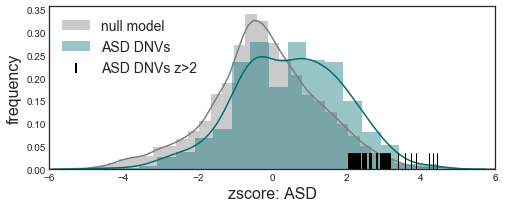

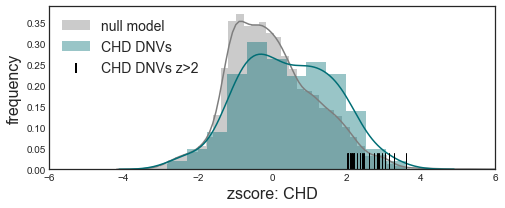

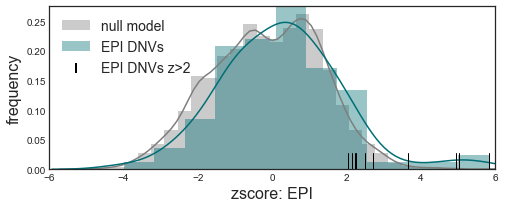

In [24]:
from scipy.stats import ks_2samp
plt.figure(figsize=(8,3))
sns.distplot(z_ASD.loc[np.setdiff1d(z_ASD.index.tolist(),ASD_HC)].dropna(),label='null model',color='#7E7E7E',kde=True)
ASD_DNV_no_seeds = list(np.setdiff1d(ASD_DNV,ASD_HC))
sns.distplot(z_ASD.loc[ASD_DNV_no_seeds].dropna(),color='#006E75',label='ASD DNVs',kde=True)
top_DNVs = z_ASD.loc[ASD_DNV_no_seeds].dropna().sort_values(ascending=False)
top_DNVs = top_DNVs[top_DNVs>2]
sns.rugplot(z_ASD.loc[top_DNVs.index.tolist()],color='k',height=.1)
ax = plt.gca()
ax.scatter([], [], marker="|", linewidth=2, color='k',s=100, label='ASD DNVs z>2') # so legend works
plt.xlabel('zscore: ASD',fontsize=16)
plt.ylabel('frequency',fontsize=16)
plt.legend(loc='best',fontsize=14)
print(top_DNVs.head(25))
print(ks_2samp(z_ASD.loc[np.setdiff1d(z_ASD.index.tolist(),ASD_HC)],z_ASD.loc[ASD_DNV_no_seeds].dropna()))
plt.xlim([-6,6])
#plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_ASD_dist.pdf',bbox_inches='tight',dpi=300)

plt.figure(figsize=(8,3))
sns.distplot(z_CHD.loc[np.setdiff1d(z_CHD.index.tolist(),CHD_HC)].dropna(),label='null model',color='#7E7E7E',kde=True)
CHD_DNV_no_seeds = list(np.setdiff1d(CHD_DNV,CHD_HC))
sns.distplot(z_CHD.loc[CHD_DNV_no_seeds].dropna(),color='#006E75',label='CHD DNVs',kde=True)
top_DNVs = z_CHD.loc[CHD_DNV_no_seeds].dropna().sort_values(ascending=False)
top_DNVs = top_DNVs[top_DNVs>2]
sns.rugplot(z_CHD.loc[top_DNVs.index.tolist()],color='k',height=.1)
ax = plt.gca()
ax.scatter([], [], marker="|", linewidth=2, color='k',s=100, label='CHD DNVs z>2') # so legend works
plt.xlabel('zscore: CHD',fontsize=16)
plt.ylabel('frequency',fontsize=16)
plt.legend(loc='best',fontsize=14)
print(top_DNVs.head(25))
print(ks_2samp(z_CHD.loc[np.setdiff1d(z_CHD.index.tolist(),CHD_HC)],z_CHD.loc[CHD_DNV_no_seeds].dropna()))
plt.xlim([-6,6])
#plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_CHD_dist.pdf',bbox_inches='tight',dpi=300)

plt.figure(figsize=(8,3))
sns.distplot(z_EPI.loc[np.setdiff1d(z_EPI.index.tolist(),EPI_HC)].dropna(),label='null model',color='#7E7E7E',kde=True)
EPI_DNV_no_seeds = list(np.setdiff1d(EPI_DNV,EPI_HC))
sns.distplot(z_EPI.loc[EPI_DNV_no_seeds].dropna(),color='#006E75',label='EPI DNVs',kde=True)
top_DNVs = z_EPI.loc[EPI_DNV_no_seeds].dropna().sort_values(ascending=False)
top_DNVs = top_DNVs[top_DNVs>2]
sns.rugplot(z_EPI.loc[top_DNVs.index.tolist()],color='k',height=.1)
ax = plt.gca()
ax.scatter([], [], marker="|", linewidth=2, color='k',s=100, label='EPI DNVs z>2') # so legend works
plt.xlabel('zscore: EPI',fontsize=16)
plt.ylabel('frequency',fontsize=16)
plt.legend(loc='upper left',fontsize=14)
print(top_DNVs.head(25))
print(ks_2samp(z_EPI.loc[np.setdiff1d(z_EPI.index.tolist(),EPI_HC)],z_EPI.loc[EPI_DNV_no_seeds].dropna()))
plt.xlim([-6,6])
#plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_EPI_dist.pdf',bbox_inches='tight',dpi=300)

In [25]:
# print out and save the unsignificant zscores
# z_unsig = z_ASD_CHD[(z_ASD_CHD<0.3)*(z_ASD_CHD>-.3)]
# z_unsig = pd.DataFrame(z_unsig)
# z_unsig['NDD-CHD_DNV'] = np.zeros(len(z_unsig))
# z_unsig['NDD-CHD_DNV'].loc[np.intersect1d(DNV_withNDD,z_unsig.index)]=1
# z_unsig = z_unsig.dropna()
# z_unsig.head()
#z_unsig.to_csv('../manuscript/tables_18_02/z_unsig.tsv',sep='\t')

In [26]:
# print out and save the non-significant zscores
z_unsig = z_ASD_EPI[(z_ASD_EPI<0.3)*(z_ASD_EPI>-.3)]
z_unsig = pd.DataFrame(z_unsig)
z_unsig['ASD-EPI_DNV'] = np.zeros(len(z_unsig))
z_unsig['ASD-EPI_DNV'].loc[np.intersect1d(ASD_EPI_DNV,z_unsig.index)]=1
z_unsig = z_unsig.dropna()
z_unsig.head()
#z_unsig.to_csv('../manuscript/tables_18_02/z_unsig_ASD_EPI.tsv',sep='\t')

,zscore,ASD-EPI_DNV
gene,,
UBE2Q2,-0.068466,0.0
REM1,0.201498,0.0
RNF17,0.112571,0.0
ZNF703,-0.230052,0.0
SPN,0.209701,0.0


# Enrichment of SFARI genes in z_ASD

In [27]:
z_ASD.sort_values(ascending=False).head()

gene
CTTNBP2    47.350731
USP45      30.431117
SHANK3     24.601011
RANBP17    23.182661
NLGN3      17.932962
Name: zscore, dtype: float64

In [28]:
# ASD enrichment for SFARI genes 
# scoring criteria: https://gene.sfari.org/about-gene-scoring/criteria/
zthresh = 2

sfari_genes = pd.read_csv('../../data/SFARI/SFARI-Gene_genes_export03-03-2018.csv',index_col='gene-symbol')
sfari_45S =sfari_genes[(sfari_genes['syndromic']==1)|(sfari_genes['gene-score']<=2.0)]
sfari_genes = sfari_45S.index.tolist()

sfari_genes_no_seeds = np.setdiff1d(sfari_genes,ASD_HC)
sfari_genes_no_seeds = np.intersect1d(sfari_genes_no_seeds,Gint.nodes()) # only keep genes in graph


# ASD z-scores?
z_thresh=2
z_ASD_g1 = z_ASD.drop(list(np.intersect1d(z_ASD.index,ASD_HC))) #list(np.setdiff1d(z_ASD_g1,CHD_HC+ASD_HC)) # don't include seeds
z_ASD_g1 = z_ASD_g1[z_ASD_g1>zthresh].index.tolist()


ASD_g1 = np.intersect1d(sfari_genes_no_seeds,z_ASD_g1)

print(len(ASD_g1))
print(len(sfari_genes_no_seeds))
print(len(z_ASD_g1))
print(len(z_ASD))

k=len(ASD_g1)
n=len(sfari_genes_no_seeds)
N = len(z_ASD_g1)
M = len(z_ASD)

ASD_enrichemnt = scipy.stats.hypergeom.sf(k,M,n,N)

print('SFARI gene enrichment in ASD = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

27
130
1064
14563
SFARI gene enrichment in ASD = 1.700346723614745e-07


# How many DNVs are found in zscore > 2? ASD, CHD, EPI alone

74
517
1064
14563
ASD enrichment = 6.636102740740588e-09
10
100
902
14563
EPI enrichment = 0.04496104600824837
30
270
917
14563
CHD enrichment = 0.0008730738577132132


Text(0,0.5,u'number recovered DNVs')

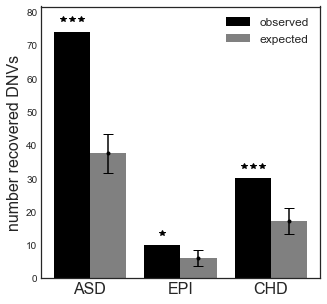

In [29]:
z_thresh = 2
num_reps=1000


# what about single ASD z-scores?
z_ASD_g1 = z_ASD[(z_ASD>z_thresh)].index.tolist()
z_ASD_g1 = list(np.setdiff1d(z_ASD_g1,ASD_HC)) # don't include seeds

ASD_DNV_in_graph = list(np.intersect1d(ASD_DNV,Gint.nodes()))
ASD_DNV_noseeds = list(np.setdiff1d(ASD_DNV_in_graph,ASD_HC))

ASD_g1 = np.intersect1d(ASD_DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(ASD_DNV_noseeds))
print(len(z_ASD_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(ASD_DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)

print('ASD enrichment = ' + str(ASD_p))

# calculate random expectation
exp_temp_ASD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(ASD_DNV_noseeds)]
    exp_temp_ASD.append(len(np.intersect1d(DNV_shuffled,z_ASD_g1)))
    



# ---------------------------------------------------------------------------
# what about single EPI z-scores?
z_EPI_g1 = z_EPI[(z_EPI>z_thresh)].index.tolist()
z_EPI_g1 = list(np.setdiff1d(z_EPI_g1,EPI_HC)) # don't include seeds

EPI_DNV_in_graph = list(np.intersect1d(EPI_DNV,Gint.nodes()))
EPI_DNV_noseeds = list(np.setdiff1d(EPI_DNV_in_graph,EPI_HC))

EPI_g1 = np.intersect1d(EPI_DNV_noseeds,z_EPI_g1)

print(len(EPI_g1))
print(len(EPI_DNV_noseeds))
print(len(z_EPI_g1))
print(len(z_EPI))

M = len(z_EPI)
n=len(EPI_DNV_noseeds)
N = len(z_EPI_g1)
k=len(EPI_g1)

EPI_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('EPI enrichment = ' + str(EPI_p))

# calculate random expectation
exp_temp_EPI = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_EPI.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(EPI_DNV_noseeds)]
    exp_temp_EPI.append(len(np.intersect1d(DNV_shuffled,z_EPI_g1)))

# ---------------------------------------------------------------------------
# what about single CHD z-scores?
z_CHD_g1 = z_CHD[(z_CHD>z_thresh)].index.tolist()
z_CHD_g1 = list(np.setdiff1d(z_CHD_g1,CHD_HC)) # don't include seeds

CHD_DNV_in_graph = list(np.intersect1d(CHD_DNV,Gint.nodes()))
CHD_DNV_noseeds = list(np.setdiff1d(CHD_DNV_in_graph,CHD_HC))

CHD_g1 = np.intersect1d(CHD_DNV_noseeds,z_CHD_g1)

print(len(CHD_g1))
print(len(CHD_DNV_noseeds))
print(len(z_CHD_g1))
print(len(z_CHD))

M = len(z_CHD)
n=len(CHD_DNV_noseeds)
N = len(z_CHD_g1)
k=len(CHD_g1)

CHD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('CHD enrichment = ' + str(CHD_p))

# calculate random expectation
exp_temp_CHD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_CHD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(CHD_DNV_noseeds)]
    exp_temp_CHD.append(len(np.intersect1d(DNV_shuffled,z_CHD_g1)))



# -------------------------------------------
# plot the results
plt.figure(figsize=(5,5))

recovered_list = [len(ASD_g1),len(EPI_g1),len(CHD_g1)]
pval_list = [ASD_p,EPI_p,CHD_p]

plt.bar([0,1,2],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_EPI),np.mean(exp_temp_CHD)],width=.4,color='gray',
       label='expected')

# add stars for significance
for i in [0,1,2]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
                

plt.errorbar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_EPI),np.mean(exp_temp_CHD)],
             [np.std(exp_temp_ASD),np.std(exp_temp_EPI),np.std(exp_temp_CHD)],fmt='k.',ecolor='k',capsize=5.0)
plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2,2.2],['ASD','EPI','CHD'],fontsize=16)
plt.ylabel('number recovered DNVs',fontsize=16)

# plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_score_num_recovered_DNVs_single_'+str(z_thresh)+'.pdf',
#           dpi=300,bbox_inches='tight')

In [31]:
for g in ASD_g1:
    print(g)

ABI2
ABL1
ADGRB3
ARHGAP5
ATP2A1
BAZ2B
BRPF1
BTAF1
CAMK2A
CBL
CCDC66
CDAN1
CDK13
CEP295
CHD4
CHD7
CLASP1
CNOT4
CNOT6
COL4A3BP
CTNNB1
DDX50
DOCK5
DSCAML1
DST
DYNC1H1
EIF4G1
EPHB1
GABRA1
GPCPD1
GRM6
GSE1
HECTD1
HERC1
IQGAP2
KAT6A
KIAA0232
KLHL25
KMT2A
LRP6
LRRFIP1
MED13
MED13L
MEGF11
MSL2
MYH10
NBEA
NCOR1
NOP53
NUP214
OSBPL8
PHF21A
PHIP
PPP2R5D
PSEN1
RELN
RORB
SF3B1
SIK1
SLC6A8
SLITRK5
SPAG9
SPECC1L
SPEN
SPTAN1
THSD7A
TLE4
TM4SF19
UBR3
USP24
VAV3
YTHDC1
ZC3H4
ZFYVE9


In [42]:
# how many DNVs are novel?  (e.g. not associated with disgenet)

# load DISgeNET file
disgenet_df = pd.read_csv('../../data/disgenet/all_gene_disease_associations.tsv',sep='\t')
disgenet_df.index=disgenet_df['diseaseName']

dis_ASD_genes = disgenet_df.loc['Autism Spectrum Disorders']['geneSymbol']
dis_ASD_genes=dis_ASD_genes.unique().tolist()
len(dis_ASD_genes)


print(np.intersect1d(dis_ASD_genes,ASD_g1))

#novel_ASD = list(np.setdiff1d(ASD_g1,dis_ASD_genes))
novel_ASD = list(np.setdiff1d(ASD_g1,sfari_genes))

z_ASD.loc[novel_ASD].sort_values(ascending=False)


[u'CHD7' u'NBEA' u'PPP2R5D' u'RELN' u'SLC6A8']


gene
ABL1        4.414939
SLC6A8      4.319047
SPTAN1      4.210641
DSCAML1     3.861720
ATP2A1      3.730202
PSEN1       3.562475
CDAN1       3.384160
CCDC66      3.172502
CNOT4       3.150932
COL4A3BP    3.148532
TLE4        3.142886
UBR3        3.109923
CTNNB1      3.087033
TM4SF19     3.072487
ADGRB3      3.062638
KIAA0232    3.033948
OSBPL8      3.015540
DST         2.987848
MEGF11      2.932045
LRP6        2.903429
CNOT6       2.808323
LRRFIP1     2.802022
RORB        2.793754
SLITRK5     2.665672
SPEN        2.656321
NOP53       2.648558
NCOR1       2.630755
HERC1       2.627250
CBL         2.619751
VAV3        2.610376
              ...   
SPECC1L     2.482091
EIF4G1      2.480426
SIK1        2.464595
SF3B1       2.409249
MSL2        2.405267
NBEA        2.371277
THSD7A      2.367095
HECTD1      2.357933
USP24       2.319985
GSE1        2.317197
DDX50       2.280936
MYH10       2.272966
PHF21A      2.271475
CEP295      2.270316
ARHGAP5     2.267388
GABRA1      2.255240
KLHL25  

In [41]:
print(len(sfari_genes))
len(np.intersect1d(sfari_genes,dis_ASD_genes))

185


62

In [32]:
z_ASD.sort_values(ascending=False,inplace=True)

#Fnew_rand_ASD_df = pd.DataFrame(Fnew_rand_ASD).T
#Fnew_rand_ASD_df.index=Fnew_ASD.index


top_idx = z_ASD.head(50).index.tolist()


In [33]:
z_ASD.loc[ASD_HC].max()

47.350730758000005

# Plot the shared-phenotype DNVs in combined z-score space

## CHD-ASD

In [34]:

combine_after_zscore=True
include_seeds=False # plot with or without seeds

z_ASD_abs = z_ASD.copy(deep=True)
ASD_HC_in_G = list(np.intersect1d(ASD_HC,Gint.nodes()))


z_CHD_abs = z_CHD.copy(deep=True)
CHD_HC_in_G = list(np.intersect1d(CHD_HC,Gint.nodes()))


z_EPI_abs = z_EPI.copy(deep=True)
EPI_HC_in_G = list(np.intersect1d(EPI_HC,Gint.nodes()))

if include_seeds==False: # remove seeds if false
    z_ASD_abs.loc[ASD_HC_in_G]=np.nan # remove the seeds
    z_CHD_abs.loc[CHD_HC_in_G]=np.nan # remove the seeds
    z_EPI_abs.loc[EPI_HC_in_G] = np.nan # remove the seeds


-5.66208739617
-3.6219353427999996
EP300
CTNNB1
PCDHA12
ETS1
KANSL1
SOS1
PPP1R12A
KAT6A
TCF12
PCBP2
CTBP2
MEIS2
TLK2
UBR3
KAT6B


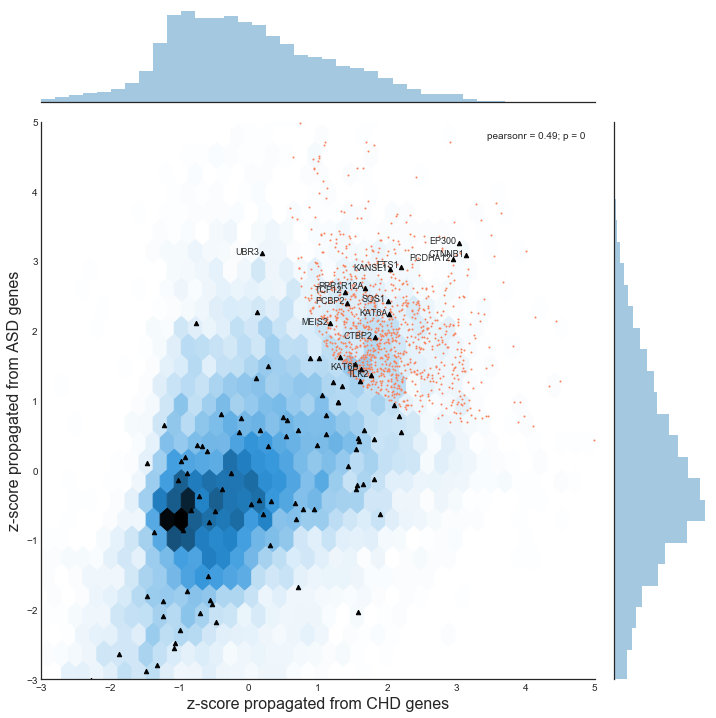

In [35]:


# -------------------- Plot on the paired disorder axes ----------------------

print(z_ASD.min())
print(z_CHD.min())
D1name='ASD'
D2name='CHD'

genes_D1 = ASD_HC
genes_D2 = CHD_HC

idx_temp = z_CHD_abs.index.tolist()

z_ASD_abs = z_ASD_abs.loc[idx_temp]

# plot the hot subnetwork
# ax4 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3,sharex=ax1,sharey=ax2)
# plt.sca(ax4)

#plt.plot((z_CHD_abs),(z_ASD_abs),'.',color='#508CC8')
# plt.hexbin(z_CHD_abs,z_ASD_abs,gridsize=50,cmap='bwr_r',extent = (-3,10,-3,10),vmax=100,vmin=-100,alpha=.5,
#           linewidths=0,edgecolor='face')
j = sns.jointplot(z_CHD_abs,z_ASD_abs,gridsize=50,kind='hex',size=10)


plt.sca(j.ax_joint)
#plt.legend().set_visible(False)


plt.xlabel('z-score propagated from '+D2name+' genes',fontsize=16)
plt.ylabel('z-score propagated from '+D1name+' genes', fontsize=16)

# plot a line such that x*y = constant

# x = np.linspace(.0001,1000,1000)
# y = mult_score/x
#plt.plot(x,y,'r-')
zthresh=2

if combine_after_zscore == True:
    z_score_both = z_CHD_abs*z_ASD_abs*(z_CHD_abs>0)*(z_ASD_abs>0)
else:
    z_score_both = z_ASD_CHD 

high_z_genes = z_score_both[z_score_both>zthresh].index.tolist()
plt.plot((z_CHD_abs[z_score_both>zthresh]),(z_ASD_abs[z_score_both>zthresh]),'.',color='#F9825C',
         ms=2,alpha=1)

# high_z_genes = z_ASD_abs[(z_ASD_abs>zthresh)*(z_CHD_abs>zthresh)].index.tolist()
# plt.plot((z_CHD_abs.loc[high_z_genes]),(z_ASD_abs.loc[high_z_genes]),'.',color='#F9825C',
#          ms=2,alpha=1)




only_D2=np.setdiff1d(genes_D2,genes_D1)
only_D1 = np.setdiff1d(genes_D1,genes_D2)
D1_and_D2 = np.intersect1d(genes_D1,genes_D2)

# draw the seed nodes with borders
only_D2_blue = list(np.intersect1d(only_D2,z_score_both[z_score_both<zthresh].index.tolist()))
only_D2_orange = list(np.intersect1d(only_D2,z_score_both[z_score_both>zthresh].index.tolist()))

only_D1_blue = list(np.intersect1d(only_D1,z_score_both[z_score_both<zthresh].index.tolist()))
only_D1_orange = list(np.intersect1d(only_D1,z_score_both[z_score_both>zthresh].index.tolist()))

plt.plot((z_CHD_abs.loc[only_D2_orange]),(z_ASD_abs.loc[only_D2_orange]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[only_D2_blue]),(z_ASD_abs.loc[only_D2_blue]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_blue]),(z_ASD_abs.loc[only_D1_blue]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_CHD_abs.loc[only_D1_orange]),(z_ASD_abs.loc[only_D1_orange]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_CHD_abs.loc[D1_and_D2]),(z_ASD_abs.loc[D1_and_D2]),'o',ms=4.5,mec='black',mew=.7,
        fillstyle='full',mfc='#F9825C')

# plot the seeds
# CHD_HC_no_ASD = list(np.setdiff1d(CHD_HC_in_G,ASD_HC_in_G))
# plt.plot(z_CHD_abs.loc[CHD_HC_no_ASD],z_ASD_abs.loc[CHD_HC_no_ASD],'s',color='k',ms=5,alpha=1)

# overlay the DNVs with NDDs
plt.plot(z_CHD_abs.loc[DNV_withNDD],z_ASD_abs.loc[DNV_withNDD],'k^',ms=4.5)

#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = ((z_ASD_abs.loc[DNV_withNDD]+10)*(z_CHD_abs.loc[DNV_withNDD]+10)).dropna().sort_values(ascending=False).head(15).index.tolist()
if include_seeds==False: # only print labels if not including seeds
    for d in DNVs_top_10:
            print(d)
            plt.annotate(d,xy=(z_CHD_abs.loc[d]-.03,z_ASD_abs.loc[d]-.01),
                       fontsize=9,rotation=0,horizontalalignment='right')

ax=plt.gca()

if include_seeds==False: # only set ades limits if not including seeds
    plt.xlim([-3,5])
    plt.ylim([-3,5])

#ax.set_yscale('log')
#ax.set_xscale('log')

fname_string = '../../manuscript/figures_18_02/'+focal_interactome+'/ASD_CHD_zscore'
if include_seeds==True:
    fname_string+='_with_seeds'
    
elif include_seeds==False:
    fname_string+='_no_seeds'
    
if combine_after_zscore==True:
    fname_string+='_combine_after_zscore.pdf'
elif combine_after_zscore==False:
    fname_string+='_combine_before_zscore.pdf'
    
#plt.savefig(fname_string,dpi=300,bbox_inches='tight')

In [36]:
'IGKV4-1' in high_z_genes

False

In [37]:
focal_genes = high_z_genes + ASD_HC_in_G + CHD_HC_in_G
len(focal_genes)
G_ASD_CHD = nx.subgraph(Gint,focal_genes)
len(G_ASD_CHD.edges())

print(len(G_ASD_CHD))

G_ASD_CHD = max(nx.connected_component_subgraphs(G_ASD_CHD), key=len)
print(len(G_ASD_CHD))

1189
1171


In [38]:
# pos = nx.spring_layout(G_ASD_CHD,weight=None)
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(G_ASD_CHD,prog='neato')
for n in pos.keys():
    pos[n]=np.array([pos[n][0]/500.0,pos[n][1]/500.0])
    
ASD_HC_no_CHD = list(np.setdiff1d(ASD_HC,CHD_HC))
CHD_HC_no_ASD = list(np.setdiff1d(CHD_HC,ASD_HC))

ASD_CHD_HC = list(np.intersect1d(ASD_HC,CHD_HC))


# pull nodes apart by ASD (left) or EPI (right)
for node in G_ASD_CHD.nodes():
    if node in ASD_HC_no_CHD:
        pos_temp = (pos[node][0]-1.5,pos[node][1])
        pos[node]=pos_temp
    elif node in CHD_HC_no_ASD:
        pos_temp = (pos[node][0]+1.5,pos[node][1])
        pos[node]=pos_temp
    elif node in ASD_CHD_HC:
        pos_temp = (pos[node][0],pos[node][1]+1.5)
        pos[node]=pos_temp
        
        
pos = pd.Series(pos)

xpos,ypos = zip(*pos.tolist())
xpos = pd.Series(xpos,index=pos.index)
ypos = pd.Series(ypos,index=pos.index)
xpos.head()

100170939    0.441200
151162       0.239860
22833        0.003874
283357       0.166670
284702       0.232960
dtype: float64

In [39]:
# from Stessman, H. A. F. et al. Targeted sequencing identifies 91 neurodevelopmental-disorder risk genes with autism and developmental-disability biases. Nat. Genet. 49, 515–526 (2017).

Stessen_table_2_genes = ['SCN2A','MED13L','ADNP','DYRK1A','GRIN2B','SETD5','SYNGAP1','NAA15','CTNNB1','POGZ',
                        'CHD8','ARID1B','ASH1L','DDX3X','SIN3A','KMT5B','SMARCC2','SCN1A','KMT2A','CDKL5','TNRC6B',
                        'DSCAM','TRIO','FOXP1','TRIP12','DLG4','CTNND2','ANK2','NFIA','DNAJC6','UNC80','ADGRL2',
                        'SLC6A1','NAV2','IQSEC','AGAP2','ERBIN','LAMC3','IQGAP3']
Stessen_non_seeds = np.setdiff1d(Stessen_table_2_genes,ASD_HC_in_G,CHD_HC_in_G)
print(len(z_ASD_CHD.loc[Stessen_non_seeds].dropna()))
z_ASD_CHD.loc[Stessen_non_seeds].dropna().sort_values(ascending=False)

16


gene
CTNNB1     4.288727
MED13L     3.521923
KMT2A      2.807599
NAV2       2.508096
CTNND2     1.865297
ADGRL2     1.512954
SMARCC2    1.444410
DLG4       1.351012
SIN3A      1.246879
NFIA       1.062154
DNAJC6     0.594094
DDX3X      0.558483
CDKL5     -0.224388
LAMC3     -0.765442
AGAP2     -0.898764
IQGAP3    -1.698466
Name: zscore, dtype: float64

In [40]:
# store node-information in a dataframe to load to cytoscape
node_info = pd.DataFrame(index=G_ASD_CHD.nodes())
node_info['ASD_CHD_DNV'] = np.zeros((len(node_info),1))
node_info['ASD_CHD_DNV'].loc[np.intersect1d(DNV_withNDD,G_ASD_CHD.nodes())]=1.0

node_info['ASD_HC'] = np.zeros((len(node_info),1))
node_info['ASD_HC'].loc[np.intersect1d(ASD_HC,G_ASD_CHD.nodes())]=1.0

node_info['CHD_HC'] = np.zeros((len(node_info),1))
node_info['CHD_HC'].loc[np.intersect1d(CHD_HC,G_ASD_CHD.nodes())]=1.0

node_info['z_ASD'] = z_ASD.loc[G_ASD_CHD.nodes()]
node_info['z_CHD'] = z_CHD.loc[G_ASD_CHD.nodes()]

node_info['z_both'] = z_ASD_CHD.loc[G_ASD_CHD.nodes()]

node_info['xpos'] = xpos.loc[G_ASD_CHD.nodes()]
node_info['ypos'] = ypos.loc[G_ASD_CHD.nodes()]

# node_info.to_csv('G_ASD_CHD_'+int_name+'nodes_180313.tsv',sep='\t') # save the nodes

[e1,e2] = zip(*G_ASD_CHD.edges())
w = pd.Series(nx.get_edge_attributes(G_ASD_CHD,'weight')).loc[G_ASD_CHD.edges()].tolist()
edge_info = pd.DataFrame({'edge1':e1,'edge2':e2,'weight':w})
#edge_info.to_csv('G_ASD_CHD_'+int_name+'edges_180313.tsv',sep='\t') # save the edges

node_info.head()

,ASD_CHD_DNV,ASD_HC,CHD_HC,z_ASD,z_CHD,z_both,xpos,ypos
84786,0.0,0.0,0.0,1.856185,2.073893,2.832616,0.086110,-0.295400
PGM2L1,0.0,0.0,0.0,2.105800,2.644882,3.023162,-0.083334,-0.194860
ZCCHC11,0.0,0.0,0.0,1.629430,1.804798,2.463478,0.012473,-0.055746
ZNF609,0.0,0.0,0.0,1.687187,2.158843,2.766490,-0.184642,-0.093094
UBL3,0.0,0.0,0.0,1.445327,1.754068,2.234129,0.075608,0.078808


In [41]:
node_info.sort_values('z_ASD',ascending=False).head(15)

,ASD_CHD_DNV,ASD_HC,CHD_HC,z_ASD,z_CHD,z_both,xpos,ypos
CTTNBP2,0.0,1.0,0.0,47.350731,1.195295,27.753490,-1.202600,0.228620
USP45,0.0,1.0,0.0,30.431117,0.066237,21.539680,-1.531008,0.280660
SHANK3,0.0,1.0,0.0,24.601011,2.211072,16.876845,-1.470868,0.295000
NLGN3,0.0,1.0,0.0,17.932962,-1.095699,10.381376,-2.051660,-0.041850
CUL3,1.0,1.0,0.0,16.323986,0.108394,9.529472,-1.372848,0.085066
TRIP12,0.0,1.0,0.0,15.874270,0.389065,8.797082,-1.337230,-0.018082
SPAST,0.0,1.0,0.0,15.518780,1.506178,9.061733,-1.359600,0.018686
INTS6,0.0,1.0,0.0,15.390641,0.584878,8.611675,-1.341434,-0.054498
NCKAP1,1.0,1.0,0.0,15.186524,1.104867,9.092388,-1.383892,0.157098
WDFY3,0.0,1.0,0.0,14.669691,1.622239,8.577167,-1.495475,0.071994


In [42]:
# create similar DFs for ASD
CHD_df = pd.DataFrame(index=z_CHD[z_CHD>2].index.tolist())
CHD_df['z_CHD']=z_CHD[z_CHD>2]

CHD_df['z_ASD']=z_ASD.loc[CHD_df.index]
CHD_df['z_both']=z_ASD_CHD.loc[CHD_df.index]


CHD_df['ASD_HC'] = np.zeros((len(CHD_df),1))
CHD_df['ASD_HC'].loc[np.intersect1d(ASD_HC,CHD_df.index)]=1.0

CHD_df['CHD_HC']=np.zeros((len(CHD_df),1))
CHD_df['CHD_HC'].loc[np.intersect1d(CHD_HC,CHD_df.index)]=1.0

CHD_df = CHD_df.sort_values('z_CHD',ascending=False)

# CHD_df.to_csv('../manuscript/tables_18_02/CHD_zscore.tsv',sep='\t')

CHD_df.head(15)

,z_CHD,z_ASD,z_both,ASD_HC,CHD_HC
MYH6,18.513572,0.865649,14.645288,0.0,1.0
ZEB2,15.643232,0.158738,10.305559,0.0,1.0
NOTCH1,14.798645,0.934574,8.982007,0.0,1.0
SMAD2,12.109927,1.769994,10.752884,0.0,1.0
PPL,11.427907,-0.246503,8.450346,0.0,1.0
PTPN11,11.359873,0.628395,9.722109,0.0,1.0
RABGAP1L,10.573857,2.769178,10.280432,0.0,1.0
CHD7,10.544050,2.175260,9.418008,0.0,1.0
RBFOX2,10.487254,1.162685,8.958781,0.0,1.0
CHD4,10.444975,2.184622,9.811512,0.0,1.0


In [43]:
# create similar DFs for CHD
ASD_df = pd.DataFrame(index=z_ASD[z_ASD>2].index.tolist())
ASD_df['z_ASD']=z_ASD[z_ASD>2]

ASD_df['z_CHD']=z_CHD.loc[ASD_df.index]
ASD_df['z_both']=z_ASD_CHD.loc[ASD_df.index]


ASD_df['ASD_HC'] = np.zeros((len(ASD_df),1))
ASD_df['ASD_HC'].loc[np.intersect1d(ASD_HC,ASD_df.index)]=1.0

ASD_df['CHD_HC']=np.zeros((len(ASD_df),1))
ASD_df['CHD_HC'].loc[np.intersect1d(CHD_HC,ASD_df.index)]=1.0

#ASD_df.to_csv('../../manuscript/tables_18_02/ASD_zscore.tsv',sep='\t')

ASD_df.head(15)

,z_ASD,z_CHD,z_both,ASD_HC,CHD_HC
CTTNBP2,47.350731,1.195295,27.753490,1.0,0.0
USP45,30.431117,0.066237,21.539680,1.0,0.0
SHANK3,24.601011,2.211072,16.876845,1.0,0.0
RANBP17,23.182661,-0.485416,14.064130,1.0,0.0
NLGN3,17.932962,-1.095699,10.381376,1.0,0.0
CUL3,16.323986,0.108394,9.529472,1.0,0.0
TRIP12,15.874270,0.389065,8.797082,1.0,0.0
SPAST,15.518780,1.506178,9.061733,1.0,0.0
INTS6,15.390641,0.584878,8.611675,1.0,0.0
NCKAP1,15.186524,1.104867,9.092388,1.0,0.0


## potential case study to highlight:

- EP300 defines a subset of rubinstein taibi syndrome http://www.malacards.org/card/rubinstein_taybi_syndrome_2
- patient 1-02464 has frameshift mutation in EP300.  Other DNV (MROH7) has very low z-score (0.0)
- Homsy et al briefly touch on EP300 as possibly important, but do not go into detail.  

- CTNNB1 also briefly touched on in homsy et al (just as part of the WNT signaling pathway)

In [44]:
#z_score_both.loc['MROH7']

## ASD-EPI

-5.66208739617
-5.0244383928
RIMS1
RIMS1
SIN3A
TTN
SPEN
SPEN
GPC5
PPP2R5D
SRGAP3
ZFYVE9
SETD2
SORBS1
CCDC87
GDI1
MAP3K10


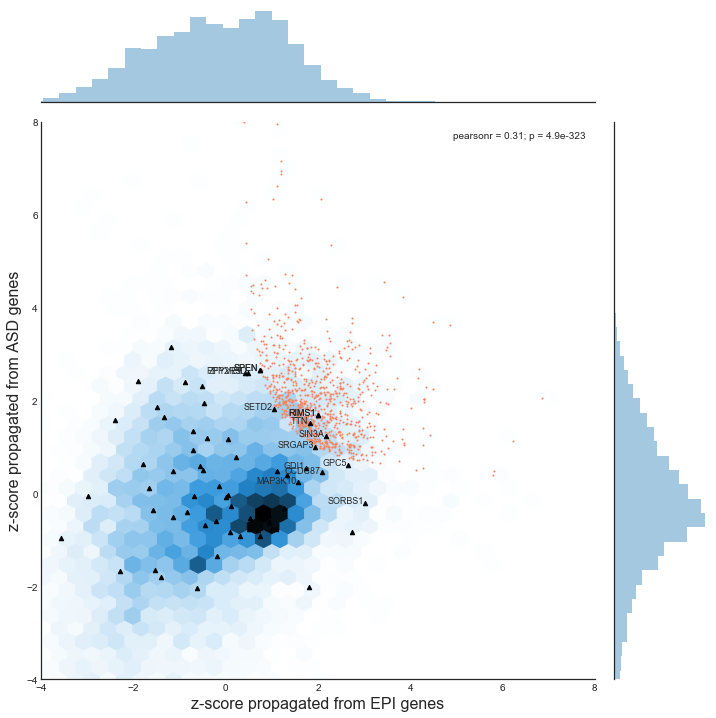

In [45]:


# -------------------- Plot on the paired disorder axes ----------------------

print(z_ASD.min())
print(z_EPI.min())
D1name='ASD'
D2name='EPI'

genes_D1 = ASD_HC
genes_D2 = EPI_HC

idx_temp = z_EPI_abs.index.tolist()

z_ASD_abs = z_ASD_abs.loc[idx_temp]

# plot the hot subnetwork
# ax4 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3,sharex=ax1,sharey=ax2)
# plt.sca(ax4)

#plt.plot((z_EPI_abs),(z_ASD_abs),'.',color='#508CC8')
# plt.hexbin(z_EPI_abs,z_ASD_abs,gridsize=50,cmap='bwr_r',extent = (-3,10,-3,10),vmax=100,vmin=-100,alpha=.5,
#           linewidths=0,edgecolor='face')
j = sns.jointplot(z_EPI_abs,z_ASD_abs,gridsize=50,kind='hex',size=10)


plt.sca(j.ax_joint)
#plt.legend().set_visible(False)


plt.xlabel('z-score propagated from '+D2name+' genes',fontsize=16)
plt.ylabel('z-score propagated from '+D1name+' genes', fontsize=16)

# plot a line such that x*y = constant

# x = np.linspace(.0001,1000,1000)
# y = mult_score/x
#plt.plot(x,y,'r-')
zthresh=2

if combine_after_zscore==True:
    z_score_both = z_EPI_abs*z_ASD_abs*(z_EPI_abs>0)*(z_ASD_abs>0)
else:
    z_score_both = z_ASD_EPI 

high_z_genes = z_score_both[z_score_both>zthresh].index.tolist()
plt.plot((z_EPI_abs[z_score_both>zthresh]),(z_ASD_abs[z_score_both>zthresh]),'.',color='#F9825C',
         ms=2,alpha=1)

# high_z_genes = z_ASD_abs[(z_ASD_abs>zthresh)*(z_EPI_abs>zthresh)].index.tolist()
# plt.plot((z_EPI_abs.loc[high_z_genes]),(z_ASD_abs.loc[high_z_genes]),'.',color='#F9825C',
#          ms=2,alpha=1)




only_D2=np.setdiff1d(genes_D2,genes_D1)
only_D1 = np.setdiff1d(genes_D1,genes_D2)
D1_and_D2 = np.intersect1d(genes_D1,genes_D2)

# draw the seed nodes with borders
only_D2_blue = list(np.intersect1d(only_D2,z_score_both[z_score_both<zthresh].index.tolist()))
only_D2_orange = list(np.intersect1d(only_D2,z_score_both[z_score_both>zthresh].index.tolist()))

only_D1_blue = list(np.intersect1d(only_D1,z_score_both[z_score_both<zthresh].index.tolist()))
only_D1_orange = list(np.intersect1d(only_D1,z_score_both[z_score_both>zthresh].index.tolist()))

plt.plot((z_EPI_abs.loc[only_D2_orange]),(z_ASD_abs.loc[only_D2_orange]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_EPI_abs.loc[only_D2_blue]),(z_ASD_abs.loc[only_D2_blue]),'o',ms=4.5,mec='#C815F0',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_EPI_abs.loc[only_D1_blue]),(z_ASD_abs.loc[only_D1_blue]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#508CC8')
plt.plot((z_EPI_abs.loc[only_D1_orange]),(z_ASD_abs.loc[only_D1_orange]),'o',ms=4.5,mec='#55CCCA',mew=.7,
        fillstyle='full',mfc='#F9825C')
plt.plot((z_EPI_abs.loc[D1_and_D2]),(z_ASD_abs.loc[D1_and_D2]),'o',ms=4.5,mec='black',mew=.7,
        fillstyle='full',mfc='#F9825C')

# plot the seeds
# EPI_HC_no_ASD = list(np.setdiff1d(EPI_HC_in_G,ASD_HC_in_G))
# plt.plot(z_EPI_abs.loc[EPI_HC_no_ASD],z_ASD_abs.loc[EPI_HC_no_ASD],'s',color='k',ms=5,alpha=1)

# overlay the DNVs with NDDs
plt.plot(z_EPI_abs.loc[ASD_EPI_DNV],z_ASD_abs.loc[ASD_EPI_DNV],'k^',ms=4.5)

#annotate top DNVs -- add 10 so we don't have to deal with multiplying negative numbers
DNVs_top_10 = ((z_ASD_abs.loc[ASD_EPI_DNV]+10)*(z_EPI_abs.loc[ASD_EPI_DNV]+10)).dropna().sort_values(ascending=False).head(15).index.tolist()
if include_seeds==False: # only display labels if not including seeds
    for d in DNVs_top_10:
            print(d)
            plt.annotate(d,xy=(z_EPI_abs.loc[d]-.03,z_ASD_abs.loc[d]-.01),
                       fontsize=9,rotation=0,horizontalalignment='right')

ax=plt.gca()

if include_seeds==False: # only set axes if not including seeds
    plt.xlim([-4,8])
    plt.ylim([-4,8])

#ax.set_yscale('log')
#ax.set_xscale('log')

fname_string = '../../manuscript/figures_18_02/'+focal_interactome+'/ASD_EPI_zscore'
if include_seeds==True:
    fname_string+='_with_seeds'
    
elif include_seeds==False:
    fname_string+='_no_seeds'
    
if combine_after_zscore==True:
    fname_string+='_combine_after_zscore.pdf'
elif combine_after_zscore==False:
    fname_string+='_combine_before_zscore.pdf'
    
#plt.savefig(fname_string,dpi=300,bbox_inches='tight')

In [46]:
focal_genes = high_z_genes + ASD_HC_in_G + EPI_HC_in_G
len(focal_genes)
G_ASD_EPI = nx.subgraph(Gint,focal_genes)
len(G_ASD_EPI.edges())

print(len(G_ASD_EPI))

G_ASD_EPI = max(nx.connected_component_subgraphs(G_ASD_EPI), key=len)
print(len(G_ASD_EPI))

966
954


In [47]:
# pos = nx.spring_layout(G_ASD_CHD,weight=None)
from networkx.drawing.nx_agraph import graphviz_layout
pos = graphviz_layout(G_ASD_EPI,prog='neato')
for n in pos.keys():
    pos[n]=np.array([pos[n][0]/500.0,pos[n][1]/500.0])
    
    
ASD_HC_no_EPI = list(np.setdiff1d(ASD_HC,EPI_HC))
EPI_HC_no_ASD = list(np.setdiff1d(EPI_HC,ASD_HC))
ASD_EPI_HC = list(np.intersect1d(ASD_HC,EPI_HC))

# pull nodes apart by ASD (left) or EPI (right)
for node in G_ASD_EPI.nodes():
    if node in ASD_HC_no_EPI:
        pos_temp = (pos[node][0]-1.5,pos[node][1])
        pos[node]=pos_temp
    elif node in EPI_HC_no_ASD:
        pos_temp = (pos[node][0]+1.5,pos[node][1])
        pos[node]=pos_temp
    elif node in ASD_EPI_HC:
        pos_temp = (pos[node][0],pos[node][1]+1.5)
        pos[node]=pos_temp
        
        
pos = pd.Series(pos)

xpos,ypos = zip(*pos.tolist())
xpos = pd.Series(xpos,index=pos.index)
ypos = pd.Series(ypos,index=pos.index)
xpos.head()

100131599    0.254660
26148        0.234520
57235        0.214260
80867        0.003065
83747        0.365940
dtype: float64

In [48]:
# store node-information in a dataframe to load to cytoscape
node_info = pd.DataFrame(index=G_ASD_EPI.nodes())
node_info['ASD_EPI_DNV'] = np.zeros((len(node_info),1))
node_info['ASD_EPI_DNV'].loc[np.intersect1d(ASD_EPI_DNV,G_ASD_EPI.nodes())]=1.0

node_info['ASD_HC'] = np.zeros((len(node_info),1))
node_info['ASD_HC'].loc[np.intersect1d(ASD_HC,G_ASD_EPI.nodes())]=1.0

node_info['EPI_HC'] = np.zeros((len(node_info),1))
node_info['EPI_HC'].loc[np.intersect1d(EPI_HC,G_ASD_EPI.nodes())]=1.0

node_info['z_ASD'] = z_ASD.loc[G_ASD_EPI.nodes()]
node_info['z_EPI'] = z_EPI.loc[G_ASD_EPI.nodes()]

node_info['z_both'] = z_ASD_EPI.loc[G_ASD_EPI.nodes()]

#node_info['xpos'] = xpos.loc[G_ASD_EPI.nodes()]
#node_info['ypos'] = ypos.loc[G_ASD_EPI.nodes()]

# node_info.to_csv('G_ASD_EPI_'+int_name+'nodes.tsv',sep='\t') # save the nodes

[e1,e2] = zip(*G_ASD_EPI.edges())
w = pd.Series(nx.get_edge_attributes(G_ASD_EPI,'weight')).loc[G_ASD_EPI.edges()].tolist()
edge_info = pd.DataFrame({'edge1':e1,'edge2':e2,'weight':w})
# edge_info.to_csv('G_ASD_EPI_'+int_name+'edges.tsv',sep='\t') # save the edges

node_info.head()

,ASD_EPI_DNV,ASD_HC,EPI_HC,z_ASD,z_EPI,z_both
HIF3A,0.0,0.0,0.0,2.235018,1.110274,2.187273
PHYHIPL,0.0,0.0,0.0,2.875986,2.628966,3.809215
ARMC9,0.0,0.0,0.0,0.951970,2.243174,2.402193
PCSK2,0.0,0.0,0.0,1.577069,2.055876,2.641709
MNT,0.0,0.0,0.0,1.380868,3.846221,3.344325


In [49]:
print(len(DNV_withNDD))
len(np.intersect1d(DNV_withNDD,Gint.nodes()))

137


122

# Calculate how many CHD-NDD DNVs are recovered above z = zthresh, in z_ASD, z_CHD, and z_ASD_CHD

And compare to number expected given hypergeometric distribution

14
116
1060
14563
ASD enrichment = 0.020995942346912547
10
116
907
14563
CHD enrichment = 0.10737992982501066
21
116
1435
14563
ASD-CHD enrichment = 0.00196837652907429


Text(0,0.5,u'number recovered NDD-CHD DNVs')

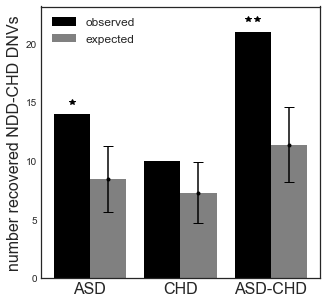

In [50]:


zthresh = 2
num_reps=1000


# what about single ASD z-scores?
z_ASD_g1 = z_ASD.drop(list(np.intersect1d(z_ASD.index,CHD_HC+ASD_HC))) #list(np.setdiff1d(z_ASD_g1,CHD_HC+ASD_HC)) # don't include seeds
z_ASD_g1 = z_ASD_g1[z_ASD_g1>zthresh].index.tolist()


DNV_noseeds = list(np.setdiff1d(DNV_withNDD,CHD_HC+ASD_HC))

ASD_g1 = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_ASD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_ASD.append(len(np.intersect1d(DNV_shuffled,z_ASD_g1)))
    
    

# ---------------------------------------------------------------------------
# what about single CHD z-scores?
z_CHD_g1 = z_CHD.drop(list(np.intersect1d(z_CHD.index,CHD_HC+ASD_HC))) # don't include seeds
z_CHD_g1 = z_CHD_g1[z_CHD_g1>zthresh].index.tolist()

DNV_noseeds = list(np.setdiff1d(DNV_withNDD,CHD_HC+ASD_HC))

CHD_g1 = np.intersect1d(DNV_noseeds,z_CHD_g1)

print(len(CHD_g1))
print(len(DNV_noseeds))
print(len(z_CHD_g1))
print(len(z_CHD))

M = len(z_CHD)
n=len(DNV_noseeds)
N = len(z_CHD_g1)
k=len(CHD_g1)

CHD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('CHD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_CHD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_CHD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_CHD.append(len(np.intersect1d(DNV_shuffled,z_CHD_g1)))
    
    
# ---------------------------------------------------------------------------
# combined ASD-CHD z-scores?

# ---- use the combined z-scores ---- 
z_both_g1 = z_ASD_CHD.sort_values(ascending=False)


# ---- OR multiply the individual z-scores ----
# z_both_g1 = z_ASD[(z_ASD>zthresh)*(z_CHD>zthresh)].index.tolist()
# z_both_g1 = z_CHD*z_ASD*(z_CHD>0)*(z_ASD>0)


z_both_g1 = z_both_g1.drop(np.intersect1d(z_both_g1.index,CHD_HC+ASD_HC))  # don't include seeds
z_both_g1 = z_both_g1[z_both_g1>zthresh].index.tolist()


DNV_noseeds = list(np.setdiff1d(DNV_withNDD,CHD_HC+ASD_HC))

both_g1 = np.intersect1d(DNV_noseeds,z_both_g1)

print(len(both_g1))
print(len(DNV_noseeds))
print(len(z_both_g1))
print(len(z_CHD))

M = len(z_CHD)
n=len(DNV_noseeds)
N = len(z_both_g1)
k=len(both_g1)

both_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-CHD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_both = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_CHD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_both.append(len(np.intersect1d(DNV_shuffled,z_both_g1)))



# -------------------------------------------
# plot the results
plt.figure(figsize=(5,5))

recovered_list = [len(ASD_g1),len(CHD_g1),len(both_g1)]
pval_list = [ASD_p,CHD_p,both_p]

plt.bar([0,1,2],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)],width=.4,color='gray',
       label='expected')

plt.errorbar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)],
             [np.std(exp_temp_ASD),np.std(exp_temp_CHD),np.std(exp_temp_both)],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1,2]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
        
plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2,2.2],['ASD','CHD','ASD-CHD'],fontsize=16)
plt.ylabel('number recovered NDD-CHD DNVs',fontsize=16)

# plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_score_num_recovered_DNVs_ASD-CHD_'+str(zthresh)+'combined_product.pdf',
#           dpi=300,bbox_inches='tight')

# Calculate how many ASD-EPI DNVs are recovered above z = zthresh, in z_ASD, z_EPI, and z_ASD_EPI

And compare to number expected given hypergeometric distribution

7
76
1063
14563
ASD enrichment = 0.18885866033741525
5
76
892
14563
EPI enrichment = 0.32159443994467357
6
76
1246
14563
ASD-EPI enrichment = 0.477567768322419


Text(0,0.5,u'number recovered ASD-EPI DNVs')

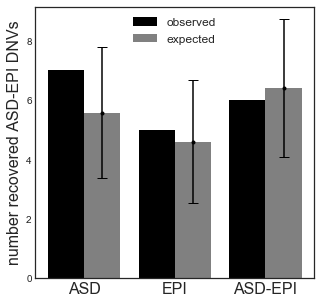

In [51]:
# compare how many ASD-EPI DNVs are recovered above z = zthresh

ASD_EPI_DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV,ASD_HC+EPI_HC))
len(ASD_EPI_DNV_noseeds)

z_ASD_EPI.loc[ASD_EPI_DNV_noseeds].sort_values(ascending=False).head(10)



zthresh = 2
num_reps=1000


# what about single ASD z-scores?
z_ASD_g1 = z_ASD.drop(list(np.intersect1d(z_ASD.index,EPI_HC+ASD_HC))) #list(np.setdiff1d(z_ASD_g1,CHD_HC+ASD_HC)) # don't include seeds
z_ASD_g1 = z_ASD_g1[z_ASD_g1>zthresh].index.tolist()


DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV_noseeds,EPI_HC+ASD_HC))

ASD_g1 = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_ASD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_ASD.append(len(np.intersect1d(DNV_shuffled,z_ASD_g1)))
    
    

# ---------------------------------------------------------------------------
# what about single EPI z-scores?
z_EPI_g1 = z_EPI.drop(list(np.intersect1d(z_EPI.index,EPI_HC+ASD_HC))) # don't include seeds
z_EPI_g1 = z_EPI_g1[z_EPI_g1>zthresh].index.tolist()

DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV_noseeds,EPI_HC+ASD_HC))

EPI_g1 = np.intersect1d(DNV_noseeds,z_EPI_g1)

print(len(EPI_g1))
print(len(DNV_noseeds))
print(len(z_EPI_g1))
print(len(z_EPI))

M = len(z_EPI)
n=len(DNV_noseeds)
N = len(z_EPI_g1)
k=len(EPI_g1)

EPI_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('EPI enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_EPI = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_EPI.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_EPI.append(len(np.intersect1d(DNV_shuffled,z_EPI_g1)))
    
    
# ---------------------------------------------------------------------------
# combined ASD-EPI z-scores?
z_both_g1 = z_ASD_EPI.sort_values(ascending=False)
z_both_g1 = z_both_g1.drop(np.intersect1d(z_both_g1.index,EPI_HC+ASD_HC))  # don't include seeds
z_both_g1 = z_both_g1[z_both_g1>zthresh].index.tolist()


DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV_noseeds,EPI_HC+ASD_HC))

both_g1 = np.intersect1d(DNV_noseeds,z_both_g1)

print(len(both_g1))
print(len(DNV_noseeds))
print(len(z_both_g1))
print(len(z_EPI))

M = len(z_EPI)
n=len(DNV_noseeds)
N = len(z_both_g1)
k=len(both_g1)

both_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-EPI enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_both = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_EPI.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_both.append(len(np.intersect1d(DNV_shuffled,z_both_g1)))

# -------------------------------------------
# plot the results
plt.figure(figsize=(5,5))

recovered_list = [len(ASD_g1),len(EPI_g1),len(both_g1)]
pval_list = [ASD_p,EPI_p,both_p]

plt.bar([0,1,2],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_EPI),np.mean(exp_temp_both)],width=.4,color='gray',
       label='expected')

plt.errorbar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_EPI),np.mean(exp_temp_both)],
             [np.std(exp_temp_ASD),np.std(exp_temp_EPI),np.std(exp_temp_both)],fmt='k.',ecolor='k',capsize=5.0)

# add stars for significance
for i in [0,1,2]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
        

plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2,2.2],['ASD','EPI','ASD-EPI'],fontsize=16)
plt.ylabel('number recovered ASD-EPI DNVs',fontsize=16)


#plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_score_num_recovered_DNVs_ASD-CHD_'+str(zthresh)+'combined_product.pdf',
#           dpi=300,bbox_inches='tight')


# Combined after propagation- how many DNVs are found in zscore > 2, 


## ASD-CHD

['CTBP2' 'CTNNB1' 'EP300' 'ETS1' 'KANSL1' 'KAT6A' 'KAT6B' 'MEIS2' 'NF1'
 'PCBP2' 'PCDHA12' 'PPP1R12A' 'SIPA1L1' 'SOS1' 'SRRM2' 'TCF12' 'TLK2']
17
102
1112
14563
ASD-CHD DNV enrichment = 0.0006584422595248949
14
102
1064
14563
ASD-CHD DNV enrichment in ASD = 0.0070575513216742
10
102
917
14563
ASD-CHD DNV enrichment in CHD = 0.05580891929923477


Text(0,0.5,u'number recovered NDD-CHD DNVs')

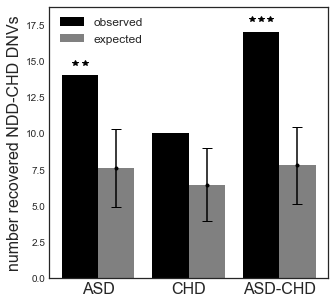

In [52]:
zthresh=2
num_reps=1000

# z_both_g1 = z_ASD[(z_ASD>zthresh)*(z_CHD>zthresh)].index.tolist()
z_both_g1 = z_CHD_abs*z_ASD_abs*(z_CHD_abs>0)*(z_ASD_abs>0)
z_both_g1 = z_both_g1[z_both_g1>zthresh].index.tolist()
z_both_g1 = list(np.setdiff1d(z_both_g1,ASD_HC+CHD_HC)) # remove HC genes

DNV_withNDD_noseeds = list(np.setdiff1d(DNV_withNDD,ASD_HC+CHD_HC))
DNV_withNDD_noseeds = list(np.intersect1d(DNV_withNDD_noseeds,Gint.nodes())) # only keep nodes in graph
NDD_g1_both = np.intersect1d(DNV_withNDD,z_both_g1)
print(NDD_g1_both)
print(len(NDD_g1_both))
print(len(DNV_withNDD_noseeds))
print(len(z_both_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DNV_withNDD_noseeds)
N = len(z_both_g1)
k=len(NDD_g1_both)

both_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-CHD DNV enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_both = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_withNDD_noseeds)]
    exp_temp_both.append(len(np.intersect1d(DNV_shuffled,z_both_g1)))
    

# ---------------------------------------------------------------------------
# what about single ASD z-scores?
z_ASD_g1 = z_ASD[(z_ASD>zthresh)].index.tolist()
z_ASD_g1 = list(np.setdiff1d(z_ASD_g1,ASD_HC))

DNV_withNDD_noseeds = list(np.setdiff1d(DNV_withNDD,ASD_HC+CHD_HC))
DNV_withNDD_noseeds = list(np.intersect1d(DNV_withNDD_noseeds,Gint.nodes())) # only keep nodes in graph

NDD_g1_ASD = np.intersect1d(DNV_withNDD_noseeds,z_ASD_g1)

print(len(NDD_g1_ASD))
print(len(DNV_withNDD_noseeds))
print(len(z_ASD_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DNV_withNDD_noseeds)
N = len(z_ASD_g1)
k=len(NDD_g1_ASD)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-CHD DNV enrichment in ASD = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_ASD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_withNDD_noseeds)]
    exp_temp_ASD.append(len(np.intersect1d(DNV_shuffled,z_ASD_g1)))

# ---------------------------------------------------------------------------
# what about single CHD z-scores?
z_CHD_g1 = z_CHD[(z_CHD>zthresh)].index.tolist()
z_CHD_g1 = list(np.setdiff1d(z_CHD_g1,CHD_HC))

DNV_withNDD_noseeds = list(np.setdiff1d(DNV_withNDD,CHD_HC+ASD_HC))
DNV_withNDD_noseeds = list(np.intersect1d(DNV_withNDD_noseeds,Gint.nodes())) # only keep nodes in graph

NDD_g1_CHD = np.intersect1d(DNV_withNDD_noseeds,z_CHD_g1)

print(len(NDD_g1_CHD))
print(len(DNV_withNDD_noseeds))
print(len(z_CHD_g1))
print(len(z_CHD))

M = len(z_CHD)
n=len(DNV_withNDD_noseeds)
N = len(z_CHD_g1)
k=len(NDD_g1_CHD)

CHD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-CHD DNV enrichment in CHD = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_CHD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_withNDD_noseeds)]
    exp_temp_CHD.append(len(np.intersect1d(DNV_shuffled,z_CHD_g1)))


    
# -------------------------------------------
# plot the results
plt.figure(figsize=(5,5))

recovered_list = [len(NDD_g1_ASD),len(NDD_g1_CHD),len(NDD_g1_both)]
pval_list = [ASD_p,CHD_p,both_p]

plt.bar([0,1,2],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)],width=.4,color='gray',
       label='expected')

# add stars for significance
for i in [0,1,2]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
                

plt.errorbar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)],
             [np.std(exp_temp_ASD),np.std(exp_temp_CHD),np.std(exp_temp_both)],fmt='k.',ecolor='k',capsize=5.0)
plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2,2.2],['ASD','CHD','ASD-CHD'],fontsize=16)
plt.ylabel('number recovered NDD-CHD DNVs',fontsize=16)

# plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_score_num_recovered_DNVs_combine_after_prop'+str(z_thresh)+'NDD-CHD.pdf',
#           dpi=300,bbox_inches='tight')

## ASD-EPI

[u'RIMS1' u'SIN3A' u'TTN']
3
64
892
14563
ASD-EPI DNV enrichment = 0.5569561021519408
7
64
1064
14563
ASD-EPI DNV enrichment in ASD = 0.09329442861633895
5
64
902
14563
ASD-EPI DNV enrichment in EPI = 0.20362830793401582


Text(0,0.5,u'number recovered ASD-EPI DNVs')

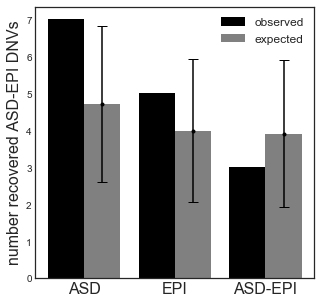

In [53]:
zthresh=2
num_reps=1000

# z_both_g1 = z_ASD[(z_ASD>zthresh)*(z_EPI>zthresh)].index.tolist()
z_both_g1 = z_EPI_abs*z_ASD_abs*(z_EPI_abs>0)*(z_ASD_abs>0)
z_both_g1 = z_both_g1[z_both_g1>zthresh].index.tolist()
z_both_g1 = list(np.setdiff1d(z_both_g1,ASD_HC+EPI_HC)) # remove HC genes

DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV,ASD_HC+EPI_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph
DNV_g1_both = np.intersect1d(DNV_noseeds,z_both_g1)
print(DNV_g1_both)
print(len(DNV_g1_both))
print(len(DNV_noseeds))
print(len(z_both_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DNV_noseeds)
N = len(z_both_g1)
k=len(DNV_g1_both)

both_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-EPI DNV enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_both = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_both.append(len(np.intersect1d(DNV_shuffled,z_both_g1)))
    

# ---------------------------------------------------------------------------
# what about single ASD z-scores?
z_ASD_g1 = z_ASD[(z_ASD>zthresh)].index.tolist()
z_ASD_g1 = list(np.setdiff1d(z_ASD_g1,ASD_HC))

DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV,ASD_HC+EPI_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph

DNV_g1_ASD = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(DNV_g1_ASD))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(DNV_g1_ASD)

ASD_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-EPI DNV enrichment in ASD = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_ASD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_ASD.append(len(np.intersect1d(DNV_shuffled,z_ASD_g1)))

# ---------------------------------------------------------------------------
# what about single EPI z-scores?
z_EPI_g1 = z_EPI[(z_EPI>zthresh)].index.tolist()
z_EPI_g1 = list(np.setdiff1d(z_EPI_g1,EPI_HC))

DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV,EPI_HC+ASD_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph

DNV_g1_EPI = np.intersect1d(DNV_noseeds,z_EPI_g1)

print(len(DNV_g1_EPI))
print(len(DNV_noseeds))
print(len(z_EPI_g1))
print(len(z_EPI))

M = len(z_EPI)
n=len(DNV_noseeds)
N = len(z_EPI_g1)
k=len(DNV_g1_EPI)

EPI_p = scipy.stats.hypergeom.sf(k,M,n,N)
print('ASD-EPI DNV enrichment in EPI = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_EPI = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_EPI.append(len(np.intersect1d(DNV_shuffled,z_EPI_g1)))


    
# -------------------------------------------
# plot the results
plt.figure(figsize=(5,5))

recovered_list = [len(DNV_g1_ASD),len(DNV_g1_EPI),len(DNV_g1_both)]
pval_list = [ASD_p,EPI_p,both_p]

plt.bar([0,1,2],recovered_list,width=.4,color='k',label='observed')
plt.bar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_EPI),np.mean(exp_temp_both)],width=.4,color='gray',
       label='expected')

# add stars for significance
for i in [0,1,2]:
    star_height = recovered_list[i]+max(recovered_list)*0.05 # add 5% of max to value
    if (pval_list[i] < 0.05) & (pval_list[i]>0.01):
        plt.plot([i],[star_height],'k*')
    elif (pval_list[i] <= 0.01) & (pval_list[i]>0.001):
        plt.plot([i-.05,i+.05],[star_height]*2,'k*')
    elif (pval_list[i] <= 0.001):
        plt.plot([i-.1,i,i+.1],[star_height]*3,'k*')
                

plt.errorbar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_EPI),np.mean(exp_temp_both)],
             [np.std(exp_temp_ASD),np.std(exp_temp_EPI),np.std(exp_temp_both)],fmt='k.',ecolor='k',capsize=5.0)
plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2,2.2],['ASD','EPI','ASD-EPI'],fontsize=16)
plt.ylabel('number recovered ASD-EPI DNVs',fontsize=16)

# plt.savefig('../../manuscript/figures_18_02/'+focal_interactome+'/z_score_num_recovered_DNVs_combine_after_prop'+str(z_thresh)+'ASD-EPI.pdf',
#           dpi=300,bbox_inches='tight')

# compare how many NDD DNVs are recovered in the topN of each z-score

7
102
500
14563
ASD enrichment = 0.024046028641582576
3
102
500
14563
CHD enrichment = 0.4660531481986363
7
102
500
14563
ASD-CHD enrichment = 0.024046028641582576


Text(0,0.5,u'number recovered NDD DNVs')

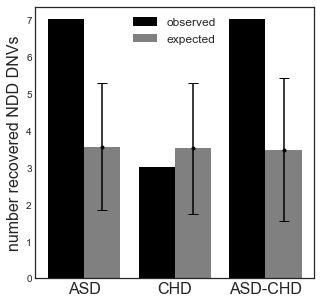

In [54]:


topN = 500
num_reps=500


# what about single ASD z-scores?
z_ASD_g1 = z_ASD.drop(list(np.intersect1d(z_ASD.index,CHD_HC+ASD_HC))) #list(np.setdiff1d(z_ASD_g1,CHD_HC+ASD_HC)) # don't include seeds
z_ASD_g1 = z_ASD_g1.sort_values(ascending=False).head(topN).index.tolist()


DNV_noseeds = list(np.setdiff1d(DNV_withNDD,CHD_HC+ASD_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph

ASD_g1 = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_enrichemnt = scipy.stats.hypergeom.sf(k,M,n,N)

print('ASD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_ASD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_ASD.append(len(np.intersect1d(DNV_shuffled,z_ASD_g1)))
    
    

# ---------------------------------------------------------------------------
# what about single CHD z-scores?
z_CHD_g1 = z_CHD.drop(list(np.intersect1d(z_CHD.index,CHD_HC+ASD_HC))) # don't include seeds
z_CHD_g1 = z_CHD.sort_values(ascending=False).head(topN).index.tolist()

DNV_noseeds = list(np.setdiff1d(DNV_withNDD,CHD_HC+ASD_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph

CHD_g1 = np.intersect1d(DNV_noseeds,z_CHD_g1)

print(len(CHD_g1))
print(len(DNV_noseeds))
print(len(z_CHD_g1))
print(len(z_CHD))

M = len(z_CHD)
n=len(DNV_noseeds)
N = len(z_CHD_g1)
k=len(CHD_g1)

print('CHD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_CHD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_CHD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_CHD.append(len(np.intersect1d(DNV_shuffled,z_CHD_g1)))
    
    
# ---------------------------------------------------------------------------
# combined ASD-CHD z-scores?
z_both_g1 = (z_ASD*z_CHD).sort_values(ascending=False)
z_both_g1 = z_both_g1.drop(np.intersect1d(z_both_g1.index,CHD_HC+ASD_HC))  # don't include seeds
z_both_g1 = z_both_g1.head(topN).index.tolist()


DNV_noseeds = list(np.setdiff1d(DNV_withNDD,CHD_HC+ASD_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph

both_g1 = np.intersect1d(DNV_noseeds,z_both_g1)

print(len(both_g1))
print(len(DNV_noseeds))
print(len(z_both_g1))
print(len(z_CHD))

M = len(z_CHD)
n=len(DNV_noseeds)
N = len(z_both_g1)
k=len(both_g1)

print('ASD-CHD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_both = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_CHD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_both.append(len(np.intersect1d(DNV_shuffled,z_both_g1)))



# -------------------------------------------
# plot the results
plt.figure(figsize=(5,5))
plt.bar([0,1,2],[len(ASD_g1),len(CHD_g1),len(both_g1)],width=.4,color='k',label='observed')
plt.bar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)],width=.4,color='gray',
       label='expected')
plt.errorbar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_CHD),np.mean(exp_temp_both)],
             [np.std(exp_temp_ASD),np.std(exp_temp_CHD),np.std(exp_temp_both)],fmt='k.',ecolor='k',capsize=5.0)
plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2,2.2],['ASD','CHD','ASD-CHD'],fontsize=16)
plt.ylabel('number recovered NDD DNVs',fontsize=16)

# plt.savefig('../../manuscript/figures_18_02/z_score_num_recovered_DNVs_ASD-CHD_'+str(topN)+'.pdf',
#            dpi=300,bbox_inches='tight')

7
64
1000
14563
ASD enrichment = 0.07054533471282683
7
64
1000
14563
EPI enrichment = 0.07054533471282683
1
64
1000
14563
ASD-EPI enrichment = 0.9401262840595777


Text(0,0.5,u'number recovered ASD-EPI DNVs')

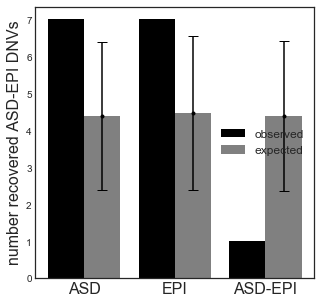

In [55]:
# compare how many ASD-EPI DNVs are recovered in the topN of each z-score

topN = 1000
num_reps=1000


# what about single ASD z-scores?
z_ASD_g1 = z_ASD.drop(list(np.intersect1d(z_ASD.index,EPI_HC+ASD_HC))) # don't include seeds
z_ASD_g1 = z_ASD_g1.sort_values(ascending=False).head(topN).index.tolist()

DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV,EPI_HC+ASD_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph

ASD_g1 = np.intersect1d(DNV_noseeds,z_ASD_g1)

print(len(ASD_g1))
print(len(DNV_noseeds))
print(len(z_ASD_g1))
print(len(z_ASD))

M = len(z_ASD)
n=len(DNV_noseeds)
N = len(z_ASD_g1)
k=len(ASD_g1)

ASD_enrichemnt = scipy.stats.hypergeom.sf(k,M,n,N)

print('ASD enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_ASD = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_ASD.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_ASD.append(len(np.intersect1d(DNV_shuffled,z_ASD_g1)))
    
    

# ---------------------------------------------------------------------------
# what about single EPI z-scores?
z_EPI_g1 = z_EPI.drop(list(np.intersect1d(z_EPI.index,EPI_HC+ASD_HC))) # don't include seeds
z_EPI_g1 = z_EPI.sort_values(ascending=False).head(topN).index.tolist()

DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV,EPI_HC+ASD_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph

EPI_g1 = np.intersect1d(DNV_noseeds,z_EPI_g1)

print(len(EPI_g1))
print(len(DNV_noseeds))
print(len(z_EPI_g1))
print(len(z_EPI))

M = len(z_EPI)
n=len(DNV_noseeds)
N = len(z_EPI_g1)
k=len(EPI_g1)

print('EPI enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_EPI = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_EPI.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_EPI.append(len(np.intersect1d(DNV_shuffled,z_EPI_g1)))
    
    
# ---------------------------------------------------------------------------
# combined ASD-EPI z-scores?
z_both_g1 = (z_ASD*z_EPI).sort_values(ascending=False)
z_both_g1 = z_both_g1.drop(np.intersect1d(z_both_g1.index,EPI_HC+ASD_HC))  # don't include seeds
z_both_g1 = z_both_g1.head(topN).index.tolist()


DNV_noseeds = list(np.setdiff1d(ASD_EPI_DNV,EPI_HC+ASD_HC))
DNV_noseeds = list(np.intersect1d(DNV_noseeds,Gint.nodes())) # only keep nodes in graph

both_g1 = np.intersect1d(DNV_noseeds,z_both_g1)

print(len(both_g1))
print(len(DNV_noseeds))
print(len(z_both_g1))
print(len(z_EPI))

M = len(z_EPI)
n=len(DNV_noseeds)
N = len(z_both_g1)
k=len(both_g1)

print('ASD-EPI enrichment = ' + str(scipy.stats.hypergeom.sf(k,M,n,N)))

# calculate random expectation
exp_temp_both = []
for r in range(num_reps):
    # calculate how many you expect to recover given hypergeo distribution
    DNV_shuffled = z_EPI.index.tolist()
    np.random.shuffle(DNV_shuffled)
    DNV_shuffled = DNV_shuffled[:len(DNV_noseeds)]
    exp_temp_both.append(len(np.intersect1d(DNV_shuffled,z_both_g1)))



# -------------------------------------------
# plot the results
plt.figure(figsize=(5,5))
plt.bar([0,1,2],[len(ASD_g1),len(EPI_g1),len(both_g1)],width=.4,color='k',label='observed')
plt.bar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_EPI),np.mean(exp_temp_both)],width=.4,color='gray',
       label='expected')
plt.errorbar([0.4,1.4,2.4],[np.mean(exp_temp_ASD),np.mean(exp_temp_EPI),np.mean(exp_temp_both)],
             [np.std(exp_temp_ASD),np.std(exp_temp_EPI),np.std(exp_temp_both)],fmt='k.',ecolor='k',capsize=5.0)
plt.legend(loc='best',fontsize=12)
plt.xticks([0.2,1.2,2.2],['ASD','EPI','ASD-EPI'],fontsize=16)
plt.ylabel('number recovered ASD-EPI DNVs',fontsize=16)

# plt.savefig('../../manuscript/figures_18_02/z_score_num_recovered_DNVs_ASD-EPI_'+str(topN)+'.pdf',
#            dpi=300,bbox_inches='tight')